In [98]:
import numpy as np # linear algebra
import pandas as pd 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math


In [99]:
from sklearn.preprocessing import (LabelEncoder,
                                   KBinsDiscretizer,
                                   StandardScaler,
                                   OneHotEncoder)

## 1

It is very important to be able to predict what contributes to high death rate for a demographic segment. The assumption being there is a dependent relationship between features like sex, country, age, generation, gdp, and suicide rate. If we can model this relationship with minimal error on unseen data, then this hypothesis has support. Then, dependeing on the model we may be able to gen a measure of feature importance to see which of these features have the most impact on the prediction.

Essentally it is important to learn the rules that 

Bayes
decision tree 
random forest

## Collect Data

In [136]:
df = pd.read_csv('data/master.csv')

## Clean

In [137]:
# Check for duplicates
sum(df.duplicated())

0

In [138]:
# Remove special symbols for convenience
rename_map = {' gdp_for_year ($) ': 'gdp_for_year', 'gdp_per_capita ($)': 'gdp_per_capita'}
df.rename(columns=rename_map, inplace=True)

In [139]:
# Make GDP integer
df['gdp_for_year'] = df['gdp_for_year'].apply(lambda x: int(x.replace(',', '')))

In [140]:
#cange sex to numerals
df['sex'] = df.sex.map({'male':0, 'female':1})
df['age'] = df.age.map({
    '5-14 years': 0, '15-24 years': 1 , 
    '25-34 years': 2, '35-54 years' : 3,
    '55-74 years': 4, '75+ years': 5})
df['generation'] = df.generation.map({
    'G.I. Generation': 6, 'Silent': 5,
    'Boomers': 4, 'Generation X' :3,
    'Millenials': 2, 'Generation Z' :1})
df.drop('country-year', inplace=True, axis=1)
df = pd.get_dummies(df, columns=['country'])

### Misisngness

In [120]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [6]:
df[df['HDI for year'].isna()]

country  year     sex          age  suicides_no  population  \
0         Albania  1987    male  15-24 years           21      312900   
1         Albania  1987    male  35-54 years           16      308000   
2         Albania  1987  female  15-24 years           14      289700   
3         Albania  1987    male    75+ years            1       21800   
4         Albania  1987    male  25-34 years            9      274300   
...           ...   ...     ...          ...          ...         ...   
27755  Uzbekistan  2009  female    75+ years            7      318983   
27756  Uzbekistan  2009  female  35-54 years           65     3263931   
27757  Uzbekistan  2009  female  55-74 years           15     1105076   
27758  Uzbekistan  2009    male   5-14 years           37     2805898   
27759  Uzbekistan  2009  female   5-14 years           18     2678474   

       suicides/100k pop    country-year  HDI for year  gdp_for_year  \
0                   6.71     Albania1987           NaN    2156624900   
1                   5.19     Albania1987           NaN    2156624900   
2                   4.83     Albania1987           NaN    2156624900   
3                   4.59     Albania1987           NaN    2156624900   
4                   3.28     Albania1987           NaN    2156624900   
...                  ...             ...           ...           ...   
27755               2.19  Uzbekistan2009           NaN   33689223673   
27756               1.99  Uzbekistan2009           NaN   33689223673   
27757               1.36  Uzbekistan2009           NaN   33689223673   
27758               1.32  Uzbekistan2009           NaN   33689223673   
27759               0.67  Uzbekistan2009           NaN   33689223673   

       gdp_per_capita       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers  
...               ...              ...  
27755            1332           Silent  
27756            1332          Boomers  
27757            1332           Silent  
27758            1332     Generation Z  
27759            1332     Generation Z  

[19456 rows x 12 columns]

## EDA

In [7]:
interval = ['age', 'generation']
ordinal = ['age', 'generation']
nominal = ['country', 'country-year', 'sex']
descrite = ['age']
binary = ['sex']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  object 
 1   year               27820 non-null  int64  
 2   sex                27820 non-null  object 
 3   age                27820 non-null  object 
 4   suicides_no        27820 non-null  int64  
 5   population         27820 non-null  int64  
 6   suicides/100k pop  27820 non-null  float64
 7   country-year       27820 non-null  object 
 8   HDI for year       8364 non-null   float64
 9   gdp_for_year       27820 non-null  int64  
 10  gdp_per_capita     27820 non-null  int64  
 11  generation         27820 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.5+ MB


In [10]:
#nominal and ordinal features
df[nominal + ordinal].describe()

country country-year    sex          age    generation
count       27820        27820  27820        27820         27820
unique        101         2321      2            6             6
top     Mauritius  Albania1987   male  15-24 years  Generation X
freq          382           12  13910         4642          6408

In [234]:
# Continuous features
df.describe()

year   suicides_no    population  suicides/100k pop  \
count  27820.000000  27820.000000  2.782000e+04       27820.000000   
mean    2001.258375    242.574407  1.844794e+06          12.816097   
std        8.469055    902.047917  3.911779e+06          18.961511   
min     1985.000000      0.000000  2.780000e+02           0.000000   
25%     1995.000000      3.000000  9.749850e+04           0.920000   
50%     2002.000000     25.000000  4.301500e+05           5.990000   
75%     2008.000000    131.000000  1.486143e+06          16.620000   
max     2016.000000  22338.000000  4.380521e+07         224.970000   

       HDI for year  gdp_for_year  gdp_per_capita  
count   8364.000000  2.782000e+04    27820.000000  
mean       0.776601  4.455810e+11    16866.464414  
std        0.093367  1.453610e+12    18887.576472  
min        0.483000  4.691962e+07      251.000000  
25%        0.713000  8.985353e+09     3447.000000  
50%        0.779000  4.811469e+10     9372.000000  
75%        0.855000  2.602024e+11    24874.000000  
max        0.944000  1.812071e+13   126352.000000

In [262]:
# from scipy.stats import normaltest
# rng = np.random.default_rng()
# x = rng.normal(size=1000)
# k2, p = normaltest(x)

# alpha = 1e-3

# print("p = {:g}".format(p))

# if p < alpha:  # null hypothesis: x comes from a normal distribution
#     print("The null hypothesis can be rejected")
# else:
#     print("The null hypothesis cannot be rejected")

### Suicides per 100K People by Year 

We need to aggregate all `suicides_no` by year add divide by the total population for that year. Then, multiplying by 100,000 will give us a better read to the number of suicides relative to the population. For, example in 1985 there were 11.5 suicides world wide per 100K people.

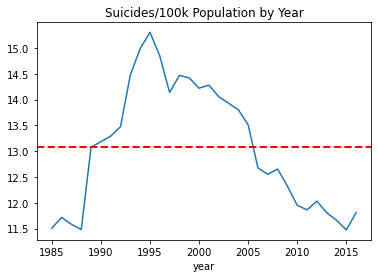

In [11]:
groupby_year =  df.groupby('year').agg(sum)
suicide__by_year = groupby_year.suicides_no / groupby_year.population * 100000
ax = suicide__by_year.plot(title='Suicides/100k Population by Year')
ax.axhline(y=suicide__by_year.mean(), xmin=0, xmax=1, color='r', linestyle='--', lw=2, label='mean')

### Suicides per 100K People by Country 

In [28]:
groupby_country =  df.groupby('country').agg(sum)
suicide__by_country = groupby_country.suicides_no / groupby_country.population * 100000
fig = px.bar(suicide__by_country.sort_values(ascending=False), labels={
                     "value": "Suicides/100k Population"
                 })
fig.show()

### Distribution of Suicides/100k Population by Country 

In [43]:
for col, df1 in df.groupby('country'):
    fig = px.histogram(df1, x ='suicides/100k pop',
                       hover_data={'year':False,'sex': True, 'age': True})
    fig.show()

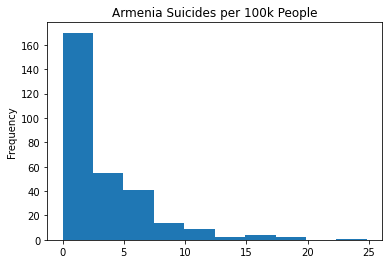

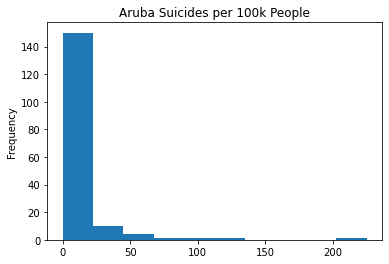

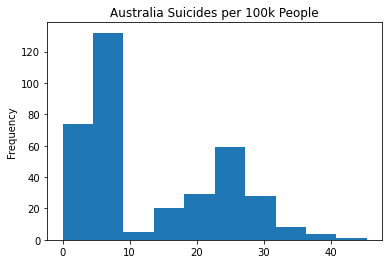

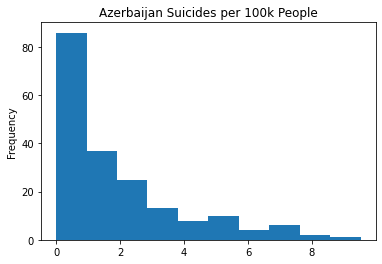

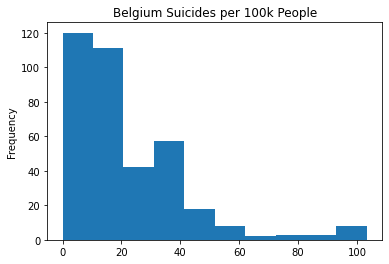

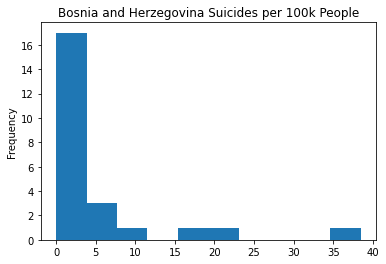

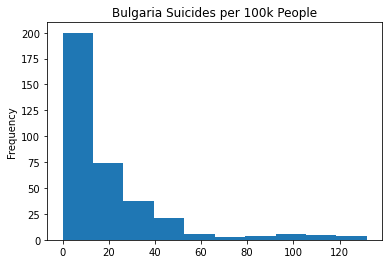

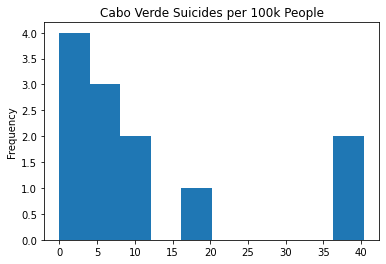

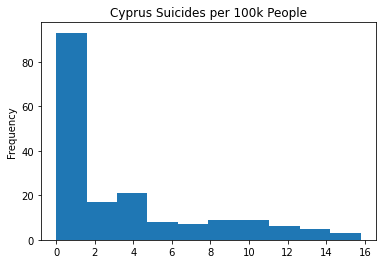

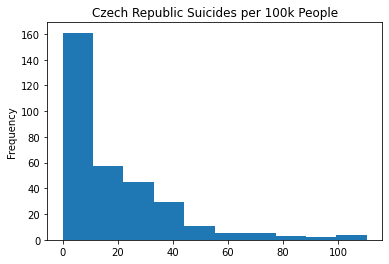

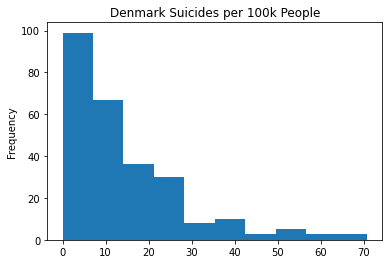

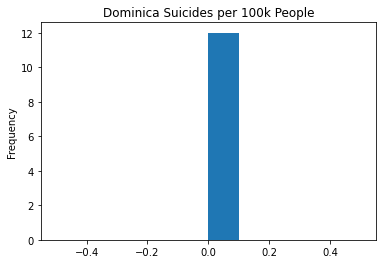

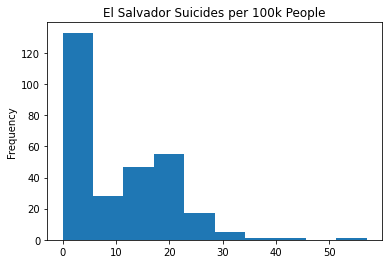

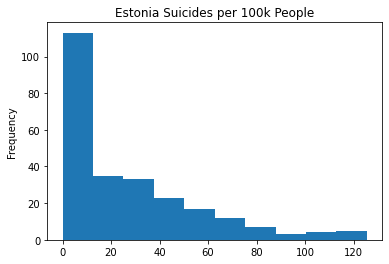

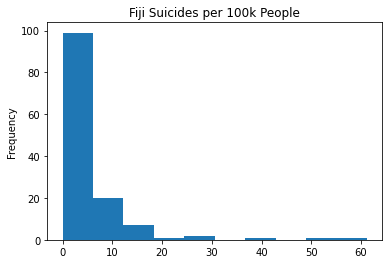

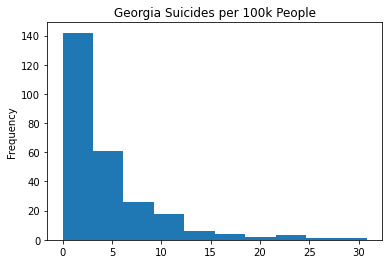

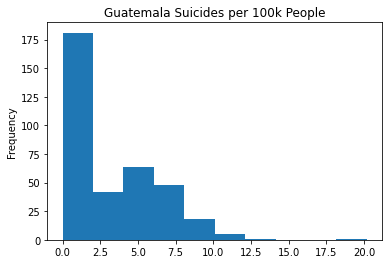

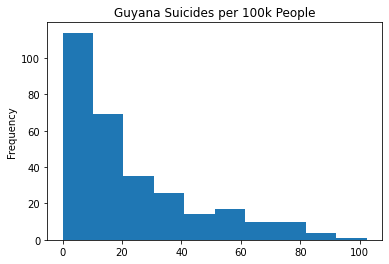

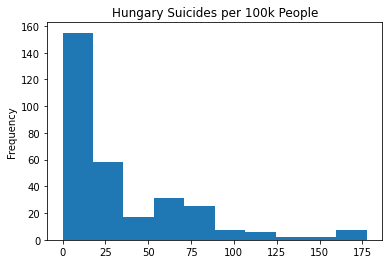

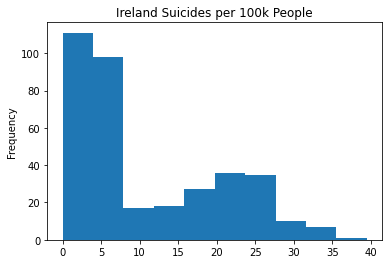

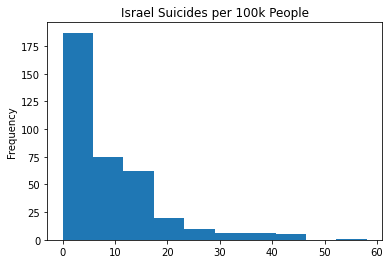

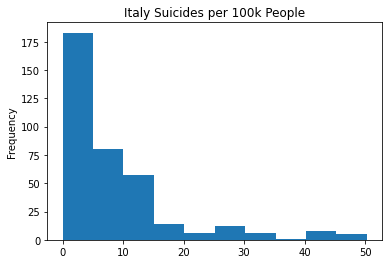

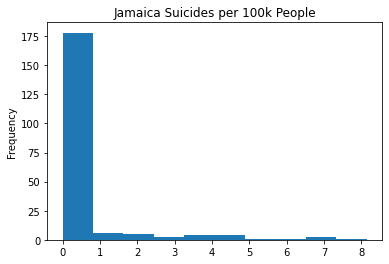

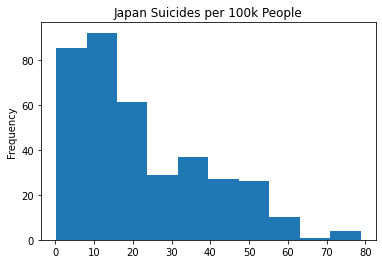

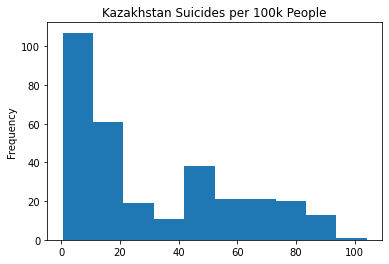

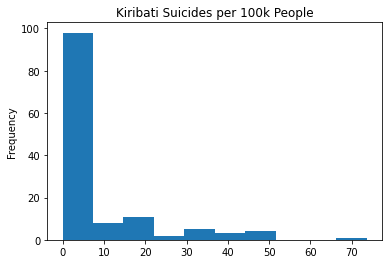

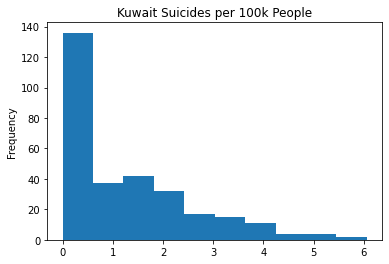

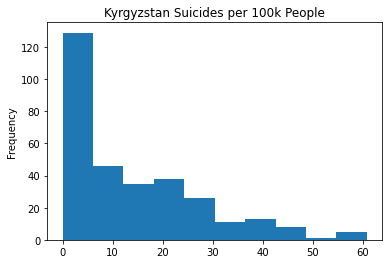

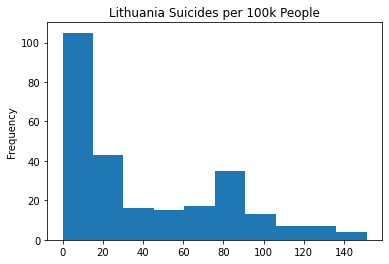

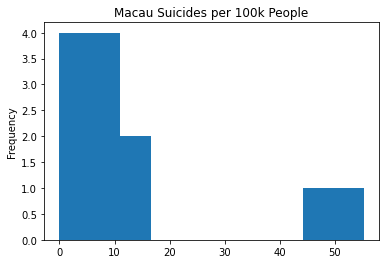

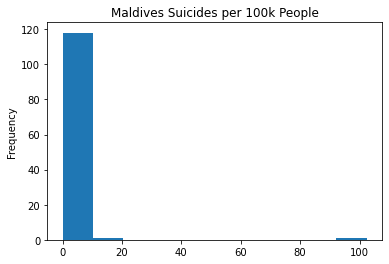

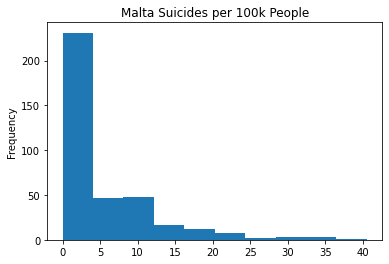

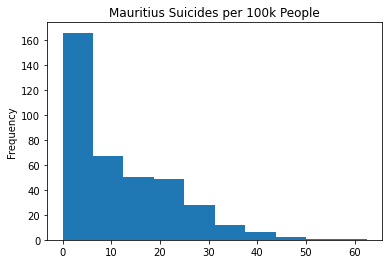

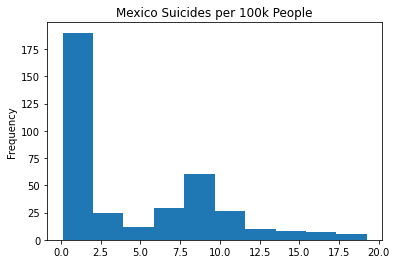

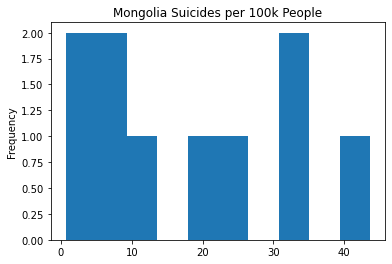

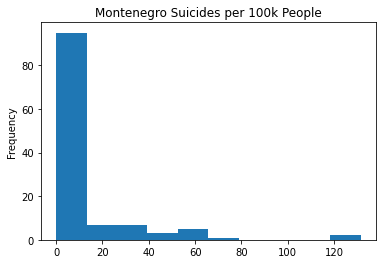

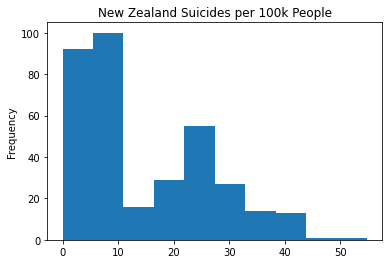

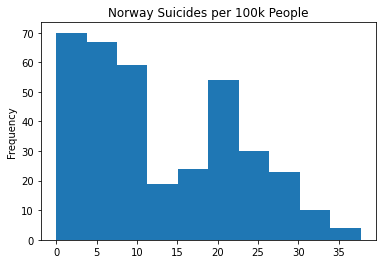

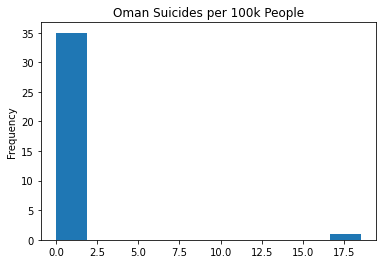

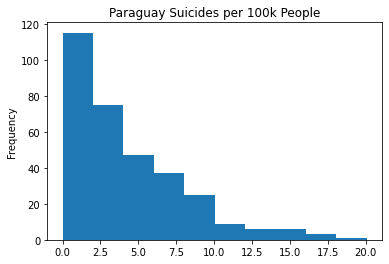

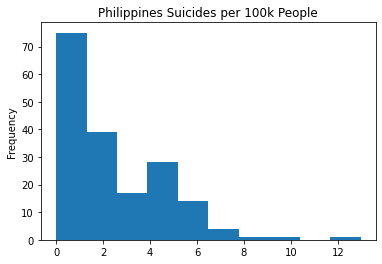

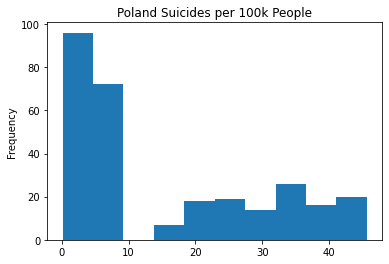

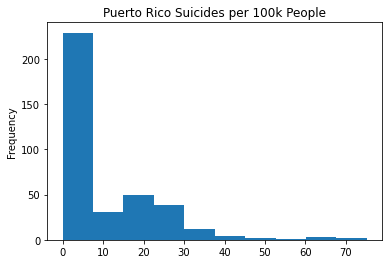

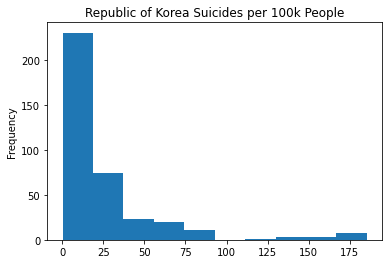

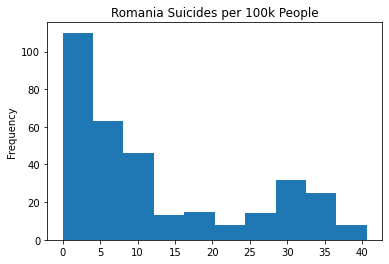

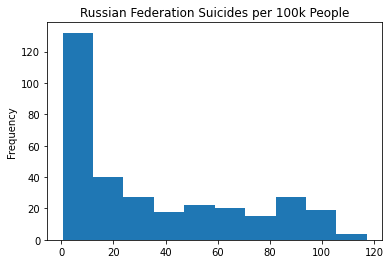

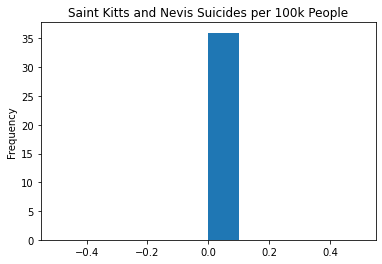

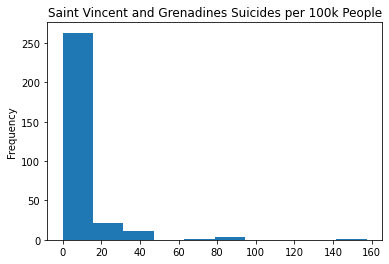

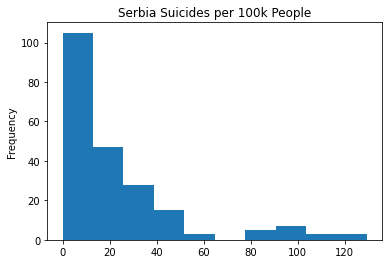

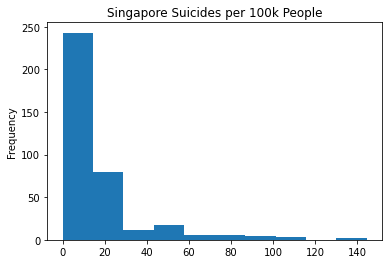

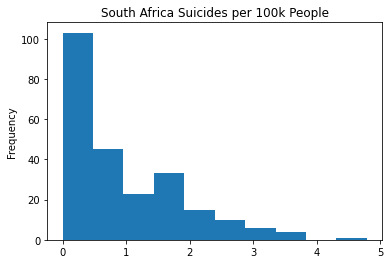

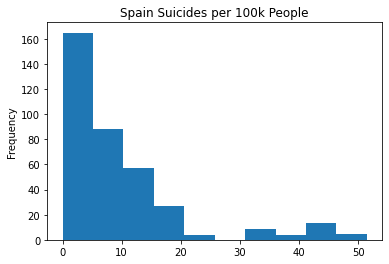

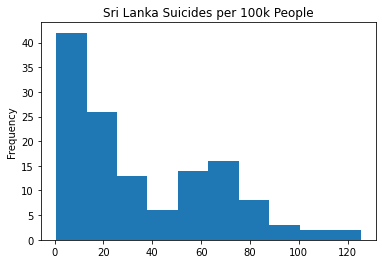

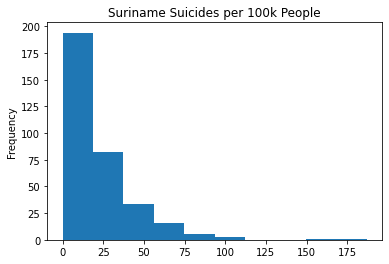

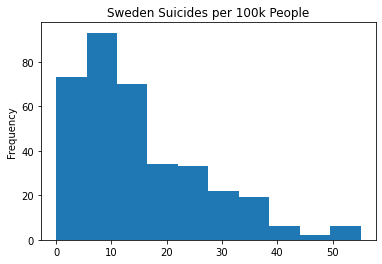

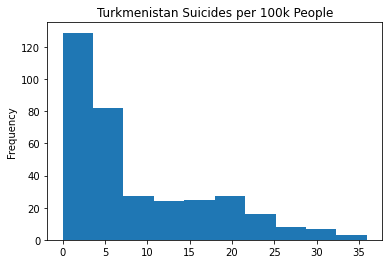

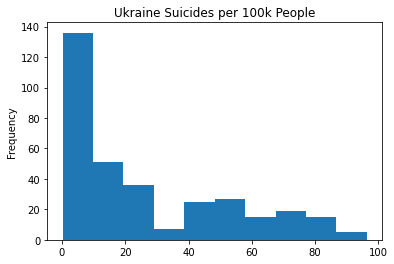

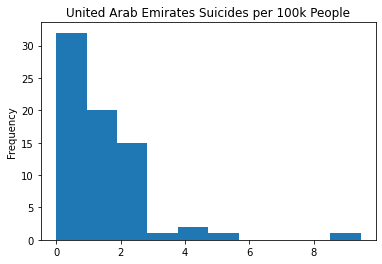

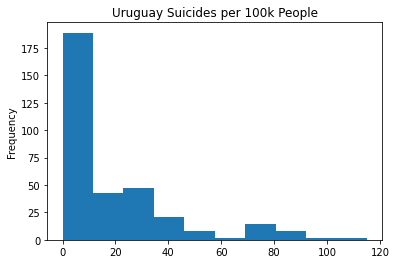

In [17]:
for col, df1 in df.groupby('country'):
    df1['suicides/100k pop'].plot(kind='hist', title=f"{col} Suicides per 100k People")
    plt.show()

In [45]:
# round_dec = lambda x, places=2: math.ceil(x * 10 ** places) / 10 ** places
# round_dec(13 / (32000 / 100000), 2)

40.63

In [113]:
df.corr()

year  suicides_no  population  suicides/100k pop  \
year                1.000000    -0.004546    0.008850          -0.039037   
suicides_no        -0.004546     1.000000    0.616162           0.306604   
population          0.008850     0.616162    1.000000           0.008285   
suicides/100k pop  -0.039037     0.306604    0.008285           1.000000   
HDI for year        0.366786     0.151399    0.102943           0.074279   
gdp_per_capita ($)  0.339134     0.061330    0.081510           0.001785   

                    HDI for year  gdp_per_capita ($)  
year                    0.366786            0.339134  
suicides_no             0.151399            0.061330  
population              0.102943            0.081510  
suicides/100k pop       0.074279            0.001785  
HDI for year            1.000000            0.771228  
gdp_per_capita ($)      0.771228            1.000000

In [114]:
sns.heatmap(df.corr())

<AxesSubplot:>

In [51]:
bool_idx = df['suicides/100k pop'] != round(df.suicides_no / (df.population / 100000), 2)
df[bool_idx] # these are just due to rounding on floating point approximations

country  year     sex          age  suicides_no  population  \
15355   Luxembourg  1989    male  55-74 years           13       32000   
15384   Luxembourg  1991    male  15-24 years            4       25600   
15942        Malta  1996    male    75+ years            1        6400   
19746  Puerto Rico  1990  female  35-54 years           13      416000   

       suicides/100k pop     country-year  HDI for year  gdp_for_year  \
15355              40.63   Luxembourg1989           NaN   10391504709   
15384              15.63   Luxembourg1991           NaN   14321878795   
15942              15.63        Malta1996           NaN    3570271558   
19746               3.13  Puerto Rico1990           NaN   30603919000   

       gdp_per_capita       generation  
15355           29239  G.I. Generation  
15384           39465     Generation X  
15942           10254  G.I. Generation  
19746            9552           Silent

### Label

In [144]:
med = df['suicides/100k pop'].median()
df['label'] = df['suicides/100k pop'].apply(lambda x: 1 if x >= med else 0)

### Model

In [123]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV

In [160]:
to_drop = ['label', 'suicides_no', 'suicides/100k pop', 'HDI for year']
X = df.drop(to_drop, axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80)

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from pipelinehelper import PipelineHelper

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('classifier', PipelineHelper([
        ('svm', LinearSVC()),
        ('rf', RandomForestClassifier()),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],  # just for displaying
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'svm__C': [0.1, 1.0],
        'rf__n_estimators': [100, 20],
    })
}
grid = GridSearchCV(pipe, params, scoring='accuracy', verbose=1)
grid.fit(X_iris, y_iris)
print(grid.best_params_)
print(grid.best_score_)